In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from Anomaly_Detection.Deep_Learning.resnet import ResNet1D
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torchsummary import summary
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import matplotlib.pyplot as plt
import seaborn as sn
from Anomaly_Detection.Deep_Learning.datasets import turbAugOnlyDataset, collate_fn_pad
import copy
from functools import partial


In [2]:
# Hyperparams
WINDOW_SIZE = 15  # the size of each data segment
SEED = 42
BATCH_SIZE = 32

# this is the number of epochs per fold, but because data is already batched,
# when larger than 1, training takes a long time, make sure you have cuda for fast training
EPOCHS = 1

SPLITS = 5


In [3]:
# Paths to data files
fdom_raw_data = "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"

turb_labeled = "Data/labeled_data/ground_truths/turb/turb_all_julian_0k-300k.csv"

fdom_raw_augmented = "Data/augmented_data/turb/unlabeled/unlabeled_fdom.csv"
turb_labeled_augmented = "Data/augmented_data/turb/labeled/labeled_turb_peaks.csv"

turb_augmented_raw_data = "Data/augmented_data/turb/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "Data/augmented_data/turb/unlabeled/unlabeled_stage.csv"

turb_fpt_lookup_path = "Data/augmented_data/turb/fpt_lookup.csv"


In [4]:
# util functions
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            print(f"reset trainable params of layer = {layer}")
            layer.reset_parameters()


In [5]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [6]:
classes = ["NAP", "FPT", "PP", "SKP"]
le = preprocessing.LabelEncoder()

targets = le.fit_transform(classes)

# this is for class balanced testing
dataset = turbAugOnlyDataset(
    le,
    fdom_raw_augmented,
    stage_augmented_data_fn,
    turb_augmented_raw_data,
    turb_labeled_augmented,
    turb_fpt_lookup_path,
)


5000 candidates found in class-balanced augmented dataset.


In [7]:
torch.manual_seed(42)
results = {}

tss = TimeSeriesSplit(SPLITS)

criterion = nn.CrossEntropyLoss().to(device)


In [8]:
# K-fold training
conf_matrices = {}
accumulated_metrics = {}

for fold, (train_ids, test_ids) in enumerate(tss.split(dataset)):
    print(f"FOLD {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    testloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=test_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    # init model
    model = ResNet1D(
        in_channels=4,
        base_filters=64,
        kernel_size=16,
        stride=2,
        n_block=48,
        groups=1,  # check this
        n_classes=len(classes),
        downsample_gap=6,
        increasefilter_gap=12,
        verbose=False,
    ).to(device)

    # set model to use float instead of doubles to prevent errors
    model = model.float()

    # init optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(0, EPOCHS):
        print(f"Starting epoch {epoch + 1}")

        current_loss = 0

        # prog bar
        prog_bar = tqdm(trainloader, desc="Training", leave=False)
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            if i == len(prog_bar) - 1:
                break

            optimizer.zero_grad()

            pred = model(x.float())
            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()

            # print stats
            current_loss += loss.item()
            if i % 500 == 499:
                print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 500))
                current_loss = 0.0

    # completed training, now test
    print(f"Training for fold {fold} has completed, now testing")

    # save best params
    save_path = f"Anomaly_Detection/Deep_Learning/results/turb/models/kfold/overfit-test-model-balanced-test-fold={fold}.pth"
    torch.save(model.state_dict(), save_path)

    total, correct = 0, 0

    # for checking correct and incorrect preds
    y_true = []
    y_pred = []

    prog_bar = tqdm(testloader, desc="Testing", leave=False)
    with torch.no_grad():
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            if i == len(prog_bar) - 1:
                break

            outputs = model(x.float())

            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(y, preds):
                # convert label and prediction to current vals
                label = label.to('cpu')
                prediction = prediction.to('cpu')
                label = le.inverse_transform([label])[0]
                prediction = le.inverse_transform([prediction])[0]

                # for confusion matrices
                y_pred.append(prediction)
                y_true.append(label)

                if label == prediction:
                    correct += 1
                total += 1

        # Print rough general accuracy
        print("Accuracy for fold %d: %d %%" % (fold, 100.0 * correct / total))
        print("--------------------------------")
        results[fold] = 100.0 * (correct / total)

        # make classification report
        acc_report = classification_report(y_true, y_pred)
        print(acc_report)

        # get acc score
        acc_score = accuracy_score(y_true, y_pred)

        bal_acc = balanced_accuracy_score(y_true, y_pred)

        f1 = f1_score(
            y_true,
            y_pred,
            average="weighted",
        )

        precision = precision_score(
            y_true,
            y_pred,
            average="weighted",
        )

        # make conf matrix
        matrix = confusion_matrix(y_true, y_pred, labels=classes)

        # save conf matrix
        conf_matrices[fold] = copy.deepcopy(matrix)

        # save accumulated metrics
        accumulated_metrics[fold] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

# Print fold results
print("\n")
print(f"K-FOLD CROSS VALIDATION RESULTS FOR {SPLITS} FOLDS")
print("--------------------------------")
sum = 0.0
for key, value in results.items():
    print(f"Fold {key}: {value} %")
    sum += value
print(f"Average: {sum/len(results.items())} %")


FOLD 0
Starting epoch 1


Training:   0%|          | 0/27 [00:00<?, ?it/s]c:\Users\clayk\Projects\srrw-peak-detection\Anomaly_Detection\Deep_Learning\datasets.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  label_list = torch.tensor(label_list, dtype=torch.int64)


Training for fold 0 has completed, now testing


c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\minicon

Accuracy for fold 0: 46 %
--------------------------------
              precision    recall  f1-score   support

         FPT       0.00      0.00      0.00       145
         NAP       0.68      0.64      0.66       227
          PP       0.00      0.00      0.00       193
         SKP       0.40      0.92      0.55       267

    accuracy                           0.47       832
   macro avg       0.27      0.39      0.30       832
weighted avg       0.31      0.47      0.36       832

FOLD 1
Starting epoch 1


Training for fold 1 has completed, now testing


c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\minicon

Accuracy for fold 1: 42 %
--------------------------------
              precision    recall  f1-score   support

         FPT       0.00      0.00      0.00       157
         NAP       0.57      0.60      0.58       203
          PP       0.25      0.03      0.05       199
         SKP       0.39      0.85      0.53       273

    accuracy                           0.43       832
   macro avg       0.30      0.37      0.29       832
weighted avg       0.32      0.43      0.33       832

FOLD 2
Starting epoch 1


Training for fold 2 has completed, now testing


c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\minicon

Accuracy for fold 2: 42 %
--------------------------------
              precision    recall  f1-score   support

         FPT       0.00      0.00      0.00       163
         NAP       0.64      0.50      0.56       209
          PP       0.25      0.07      0.11       190
         SKP       0.39      0.89      0.54       270

    accuracy                           0.43       832
   macro avg       0.32      0.36      0.30       832
weighted avg       0.35      0.43      0.34       832

FOLD 3
Starting epoch 1


Training for fold 3 has completed, now testing


Accuracy for fold 3: 42 %
--------------------------------
              precision    recall  f1-score   support

         FPT       0.34      0.10      0.15       155
         NAP       0.66      0.55      0.60       211
          PP       0.29      0.10      0.15       203
         SKP       0.37      0.76      0.50       263

    accuracy                           0.42       832
   macro avg       0.41      0.38      0.35       832
weighted avg       0.42      0.42      0.37       832

FOLD 4
Starting epoch 1


Training for fold 4 has completed, now testing


Accuracy for fold 4: 47 %
--------------------------------
              precision    recall  f1-score   support

         FPT       0.60      0.02      0.04       162
         NAP       0.69      0.62      0.65       211
          PP       0.45      0.13      0.20       193
         SKP       0.41      0.89      0.56       266

    accuracy                           0.48       832
   macro avg       0.54      0.41      0.36       832
weighted avg       0.53      0.48      0.40       832



K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 46.875 %
Fold 1: 42.90865384615385 %
Fold 2: 42.90865384615385 %
Fold 3: 42.1875 %
Fold 4: 47.59615384615385 %
Average: 44.49519230769231 %


Mean Test F1:  0.3595592215576117
Mean Test BA:  0.38225739585651797
Mean Test Acc:  0.4449519230769231
Mean Test Precision:  0.3858297481214653


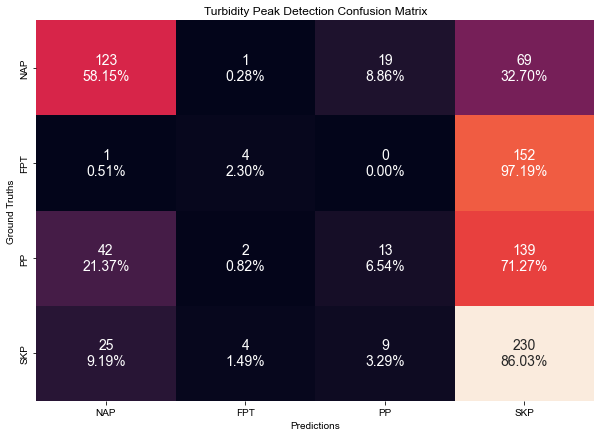

In [9]:
# save accumulated metrics
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_metrics:
    metrics = accumulated_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_metrics))

# make mean confusion matrix
mean_cfmx = np.zeros((len(classes), len(classes)))
for key in conf_matrices.keys():
    mean_cfmx += conf_matrices[key]

mean_cfmx = mean_cfmx / len(conf_matrices)

plt.figure(figsize=(10, 7))
plt.title(label="Turbidity Peak Detection Confusion Matrix")

sn.set(font_scale=1.5)

group_counts = ["{0:0.0f}\n".format(value) for value in mean_cfmx.flatten()]
percentages = (mean_cfmx / mean_cfmx.sum(axis=1)[:, np.newaxis]).flatten()
group_percentages = ["{0:.2%}".format(value) for value in percentages]

box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(mean_cfmx.shape[0],mean_cfmx.shape[1])

plot = sn.heatmap(
    mean_cfmx.astype("float"),
    annot=box_labels,
    xticklabels=classes,
    yticklabels=classes,
    fmt="",
    cbar=False,
    annot_kws={"size": 14},
)

plot.patch.set_facecolor('xkcd:white')

plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

plot.get_figure().savefig(
    "Anomaly_Detection/Deep_Learning/results/turb/graphics/base-test-kfold.png"
)
